# langsung dari library efficientnet

In [1]:
import warnings
warnings.filterwarnings("ignore") # fp16 scaling really bugging the shit out of jupyter lab, results in RAM memory leak. :(

In [2]:
# list all train images + labels according to folders -> df
import pandas as pd
from fastai.vision import *

def get_data(bs, size): 
    tfms = get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20, xtra_tfms=[flip_lr()])
    return ImageDataBunch.from_folder(Path('./dataset'),
                                  train = 'train/',
                                  valid_pct = 0.1,
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms = tfms,
                                  size = size,
                                  bs = bs,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

data = get_data(64, 299)
img_path = [str(x) for x in list(data.train_ds.items)] + list(data.valid_ds.items)
labels = [data.classes[x] for x in list(data.train_ds.y.items) + list(data.valid_ds.y.items)]
# del data

In [73]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()

In [74]:
learn.load('baseline')

Learner(data=ImageDataBunch;

Train: LabelList (105826 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
test,test,test,test,test
Path: dataset;

Valid: LabelList (11758 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
40,20,17,13,30
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d

In [75]:
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (105826 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
test,test,test,test,test
Path: dataset;

Valid: LabelList (11758 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
40,20,17,13,30
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d

In [76]:
learn.export()

In [64]:
learn = load_learner('./dataset')

In [65]:
# Second last layer of the model
learn.model[1][4]

Linear(in_features=4096, out_features=512, bias=True)

In [6]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [7]:
sf = SaveFeatures(learn.model[1][4])

In [ ]:
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [43]:
test = learn.data.train_ds[2][0]

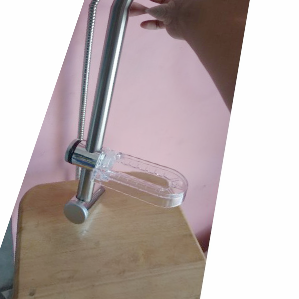

In [44]:
test

In [54]:
sf = SaveFeatures(learn.model[1][4])
_ = learn.predict(test)
len(sf.features)

1

In [55]:
sf.features[0]

array([-37.03  ,  31.05  ,  -0.3557, -33.66  , ...,  14.58  ,   6.53  ,  39.97  , -43.16  ], dtype=float16)

In [32]:
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]

In [72]:
img_path[23]

'dataset/test/004df33b3487b4691f638c5603341901.jpg'

In [9]:
len(img_path), len(label), len(label_id)

(117584, 117584, 117584)

In [ ]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
df_new

In [ ]:
feature_vectors = np.array(sf.features)
x = feature_vectors.tolist()

In [ ]:
df_new['vectors'] = x

In [ ]:
df_new.head()

In [ ]:
df_new.to_pickle('image_Resnet50_vectors.pkl')

In [10]:
df_new = pd.read_pickle('./dataset/models/image_Resnet50_vectors.pkl')

In [ ]:
!pip install pyarrow annoy

In [11]:
from annoy import AnnoyIndex

f = len(df_new['vectors'][0])
tt = AnnoyIndex(f, metric='euclidean')

In [12]:
f

512

In [13]:
n_tree = 100

for i, v in enumerate(df_new['vectors']): 
    tt.add_item(i, v)
_ = tt.build(n_tree)

In [14]:
tt.save('baseline_annoy.ann')

True

In [15]:
import time
def get_similar_image_by_index(img_index, df=df_new, t = tt): 
    start = time.time()
    base_img_id, base_vec, base_label = df.iloc[img_index, [0,3,1]]
    similar_img_ids = t.get_nns_by_item(img_index, 8)
    
    end = time.time() - start
    print(end, 's')
    return base_img_id, base_label, df.iloc[similar_img_ids]

In [36]:
import time
def get_similar_image_by_vector(img_vector, df=df_new, t = tt): 
    start = time.time()
    similar_img_ids = t.get_nns_by_vector(img_vector, 8)
    
    end = time.time() - start
    print(end, 's')
    return df.iloc[similar_img_ids]

In [56]:
sim_df_by_vec = get_similar_image_by_vector(sf.features[0])

0.0021376609802246094 s


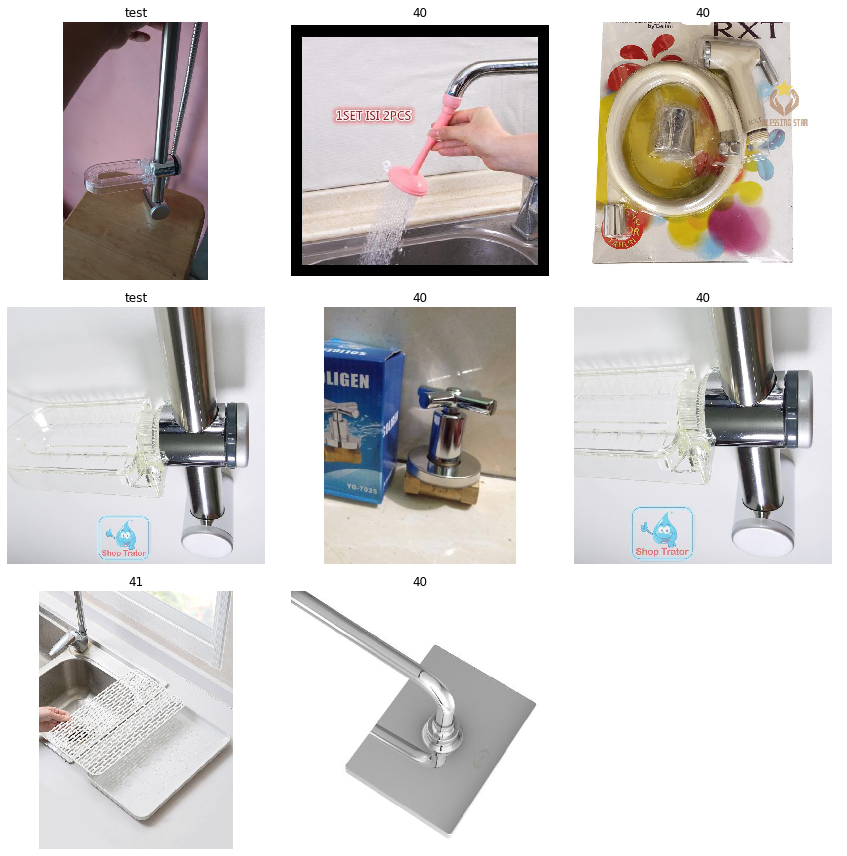

In [57]:
show_similar_images(sim_df_by_vec)

In [16]:
base_img, base_label, similar_images_df = get_similar_image_by_index(42)

0.0032515525817871094 s


In [23]:
base_img

'dataset/test/010a7e98e85214c5e3c49df506e8055f.jpg'

In [17]:
similar_images_df

,img_path,label,label_id,vectors
42,dataset/test/010a7e98e85214c5e3c49df506e8055f.jpg,test,42,"[14.4609375, -23.78125, 13.3046875, 7.1015625,..."
52600,dataset/train/17/fb9fe2fd7a1cff47f248551bda2aa...,17,17,"[14.0546875, -23.21875, 13.1171875, 7.34375, -..."
109524,dataset/train/17/51a36389819a1d723e824723372e2...,17,17,"[14.265625, -23.34375, 12.9453125, 7.484375, -..."
51266,dataset/train/17/027a9c66fce0c2b85646dde69b148...,17,17,"[12.0703125, -24.484375, 13.1640625, 1.34375, ..."
52546,dataset/train/17/f0b7d1b2c3bbd3b4af225167d43a8...,17,17,"[16.15625, -21.09375, 28.796875, 20.9375, -26...."
52430,dataset/train/17/d9ebf3d77e4deaac37936f0eda9e8...,17,17,"[16.28125, -20.46875, 28.046875, 19.421875, -2..."
51727,dataset/train/17/5cb76639dc28323cc7c23b6725336...,17,17,"[12.7109375, -18.671875, 29.71875, 23.078125, ..."
64566,dataset/train/23/38f80034ab250381fe16d3d3eb656...,23,23,"[4.953125, 6.44921875, 25.328125, 34.3125, -14..."


In [ ]:
learn.get_preds(data.train_ds)

In [24]:
learn.predict

LabelList (105826 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
test,test,test,test,test
Path: dataset

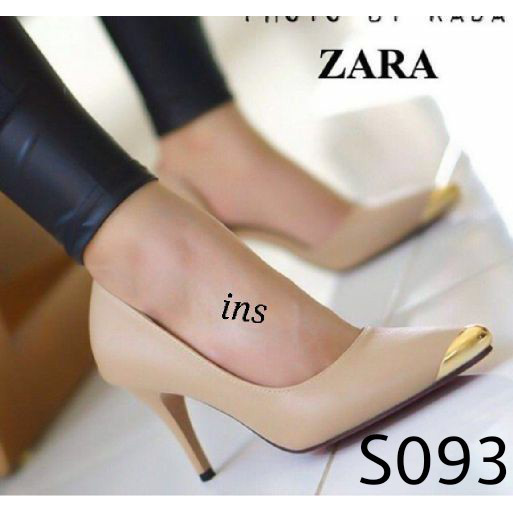

In [18]:
open_image(base_img)

In [39]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

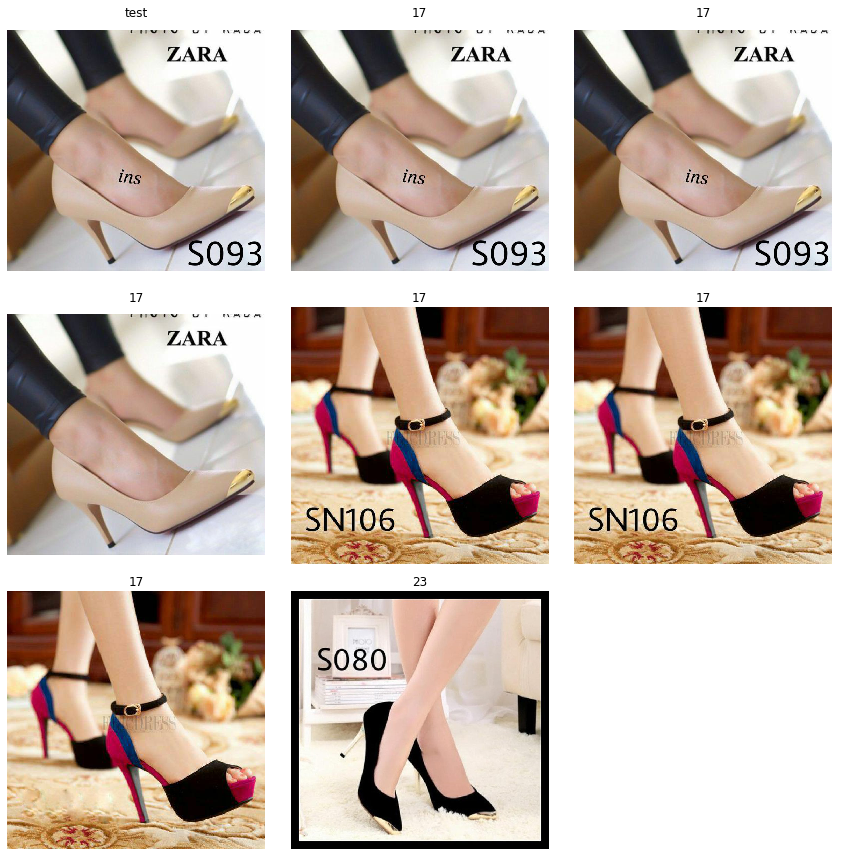

In [20]:
show_similar_images(similar_images_df)

In [24]:
from sklearn.decomposition import PCA

img_repr_matrix = [list(x) for x in df_new['vectors'].values]
pca = PCA(n_components=3)
pca_result_3= pca.fit_transform(img_repr_matrix)

In [25]:
df_new['pca_x'] = pca_result_3[:,0]
df_new['pca_y'] = pca_result_3[:,1]
df_new['pca_z'] = pca_result_3[:,2]

In [28]:
df_new.to_csv('hasil_pca.csv', index=False)

In [26]:
import plotly_express as px
px.scatter_3d(df_new, x='pca_x', y='pca_y', z='pca_z', color='label')

ModuleNotFoundError: No module named 'plotly_express'

In [ ]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in df_new['vectors'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100, n_jobs=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

In [ ]:
!pip install sklearn

In [ ]:
df_new['tsne1'] = tsne_results_3[:,0]
df_new['tsne2'] = tsne_results_3[:,1]
df_new['tsne3'] = tsne_results_3[:,2]

In [ ]:
df_new.to_pickle('shopee_baseline_with_tsne.pkl')

In [ ]:
import plotly_express as px
px.scatter_3d(df_new, x='tsne1', y='tsne2', z='tsne3', color='label')

# check with annoy

In [21]:
f = 512 # dimension vector image nya (resnet 50 pake 512)
u = AnnoyIndex(f, 'euclidean')
u.load('./baseline_annoy.ann')

random_search = u.get_nns_by_item(2,3)

In [22]:
random_search

[2, 41451, 10446]